# Определение перспективного тарифа для телеком-компании.
**Описание проекта**
>Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Проводим предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание данных**
1) Таблица users (информация о пользователях):
user_id — уникальный идентификатор пользователя
first_name — имя пользователя
last_name — фамилия пользователя
age — возраст пользователя (годы)
reg_date — дата подключения тарифа (день, месяц, год)
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
city — город проживания пользователя
tariff — название тарифного плана
2) Таблица calls (информация о звонках):
id — уникальный номер звонка
call_date — дата звонка
duration — длительность звонка в минутах
user_id — идентификатор пользователя, сделавшего звонок
3) Таблица messages (информация о сообщениях):
id — уникальный номер сообщения
message_date — дата сообщения
user_id — идентификатор пользователя, отправившего сообщение
Таблица internet (информация об интернет-сессиях):
id — уникальный номер сессии
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
session_date — дата интернет-сессии
user_id — идентификатор пользователя
4) Таблица tariffs (информация о тарифах):
tariff_name — название тарифа
rub_monthly_fee — ежемесячная абонентская плата в рублях
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
messages_included — количество сообщений в месяц, включённых в абонентскую плату
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
rub_per_message — стоимость отправки сообщения сверх тарифного пакета
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [1]:
#импортируем все необходимые нам библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st

#открываем файлы
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

#смотрим
display(calls.head(15))
print(calls.info())

display(internet.head(15))
print(internet.info())

display(messages.head(15))
print(messages.info())

display(tariffs.head(15))
print(tariffs.info())

display(users.head(15))
print(users.info())


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


**Вывод**
1. В столбцах "call_date", "session_date", "message_date", "churn_date", "reg_date" неверный формат даты, необходимо перевести в формат datetime.
2. В столбце "duration", необходимо округлить время звонков в большую сторону в соответствии с условиями тарифов.

In [2]:
#приводим данные в формат datetime
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

#округляем в большую сторону время звонков
def ceil_value(value):
    return math.ceil(value)
calls['duration'] = calls['duration'].apply(ceil_value)

#создаём столбцы с месяцами
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

#проверяем
display(calls.head(15))
print(calls.info())

display(internet.head(15))
print(internet.info())

display(messages.head(15))
print(messages.info())

display(tariffs.head(15))
print(tariffs.info())

display(users.head(15))
print(users.info())

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
5,1000_5,2018-11-02,0,1000,11
6,1000_6,2018-10-18,0,1000,10
7,1000_7,2018-08-22,19,1000,8
8,1000_8,2018-09-15,19,1000,9
9,1000_9,2018-08-15,0,1000,8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
 4   month      202607 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 7.7+ MB
None


,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,11
1,1,1000_1,1052.81,2018-09-07,1000,9
2,2,1000_2,1197.26,2018-06-25,1000,6
3,3,1000_3,550.27,2018-08-22,1000,8
4,4,1000_4,302.56,2018-09-24,1000,9
5,5,1000_5,399.97,2018-10-02,1000,10
6,6,1000_6,540.08,2018-09-07,1000,9
7,7,1000_7,415.70,2018-07-11,1000,7
8,8,1000_8,505.40,2018-10-08,1000,10
9,9,1000_9,345.54,2018-09-03,1000,9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
 5   month         149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 6.8+ MB
None


,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
5,1000_5,2018-06-20,1000,6
6,1000_6,2018-11-19,1000,11
7,1000_7,2018-10-29,1000,10
8,1000_8,2018-06-25,1000,6
9,1000_9,2018-12-18,1000,12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
 3   month         123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.8+ MB
None


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaT,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaT,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaT,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaT,Пермь,Василиса,Блинова,2018-03-22,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB
None


**Вывод**
Ошибки исправлены, столбцы с месяцами для дальнеших рассчётов добавлены.

In [3]:
#делаем рассчёты
#создаём сводную таблицу и считаем: количество сделанных звонков
#и израсходованных минут разговора по месяцам для каждого пользователя
calls_grouped = calls.pivot_table(index=['user_id', 'month'], values='duration',
                                  aggfunc=['sum', 'count'])
calls_grouped.reset_index()
calls_grouped.columns = ['calls_duration', 'calls_amount']
display(calls_grouped.head(15))

#создаём сводную таблицу и считаем: количество отправленных сообщений по месяцам
#для каждого пользователя
messages_grouped = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_grouped.reset_index()
messages_grouped.columns=['messages_amount']
display(messages_grouped.head(15))

#в таблице с информацией об интернет-сессиях для дальнейшего анализа переведем Мб в Гб(как в тарифе)
internet['gb_used'] = internet['mb_used'] / 1024
#создаём сводную таблицу и считаем: объем израсходованного интернет-трафика по месяцам
#для каждого пользователя
internet_grouped = internet.pivot_table(index=['user_id', 'month'], values='gb_used', aggfunc=['sum'])
internet_grouped.columns = ['gb_used']
internet_grouped.reset_index()
display(internet_grouped.head(15))

#соединим все данные в одну таблицу для дальнейшего анализа
total_data_1 = calls_grouped.join([internet_grouped, messages_grouped], how='outer').reset_index(level='month')
total_data = users.join(total_data_1, on='user_id', how='outer')
display(total_data.head(15))

#округляем Гб для удобства дальнейших рассчётов
total_data['gb_used'] = total_data['gb_used'].apply(np.ceil)
display(total_data.head())

#считаем помесячную выручку с каждого пользователя, для этого созаём функцию с учётом данных тарифов
def revenue(row):
    if row['tariff'] == 'smart':
        if row['messages_amount'] > 50:
            messages_extra = (row['messages_amount'] - 50)*3
        else:
            messages_extra = 0
        if row['calls_amount'] > 500:
            calls_extra = (row['calls_amount'] - 500)*3
        else:
            calls_extra = 0
        if row['gb_used'] > 15:
            gb_extra = (row['gb_used'] - 15)*200
        else:
            gb_extra = 0
        total_cost = messages_extra + calls_extra + gb_extra + 550
    if row['tariff'] == 'ultra':
        if row['messages_amount'] > 1000:
            messages_extra = (row['messages_amount'] - 1000)*1
        else:
            messages_extra = 0
        if row['calls_amount'] > 3900:
            calls_extra = (row['calls_amount'] - 3000)*1
        else:
            calls_extra = 0
        if row['gb_used'] > 30:
            gb_extra = (row['gb_used'] - 30)*150
        else:
            gb_extra = 0
        total_cost = messages_extra + calls_extra + gb_extra + 1950
    return total_cost

#добавляем столбец "total_cost" в таблицу(в нём помесячная выручка с каждого пользователя) 
total_data['total_cost'] = total_data.apply(revenue, axis=1)
total_data.pivot_table(index=['user_id', 'first_name', 'last_name', 'age', 'city', 'tariff', 'reg_date', 'churn_date', 'month'])
display(total_data.head(15))


calls_duration  calls_amount
user_id month                              
1000    5                 159            22
        6                 172            43
        7                 340            47
        8                 408            52
        9                 466            58
        10                350            57
        11                338            43
        12                333            46
1001    11                430            59
        12                414            63
1002    6                 117            15
        7                 214            26
        8                 289            42
        9                 206            36
        10                212            33

messages_amount
user_id month                 
1000    5                   22
        6                   60
        7                   75
        8                   81
        9                   57
        10                  73
        11                  58
        12                  70
1002    6                    4
        7                   11
        8                   13
        9                    4
        10                  10
        11                  16
        12                  12

gb_used
user_id month           
1000    5       2.200674
        6      22.689229
        7      13.675430
        8      13.726494
        9      14.227451
        10     14.357900
        11     14.410615
        12      9.587510
1001    11     17.997402
        12     13.707676
1002    6      10.602363
        7      17.168066
        8      19.843027
        9      16.299883
        10     13.562744

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_duration,calls_amount,gb_used,messages_amount
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,159.0,22.0,2.200674,22.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,172.0,43.0,22.689229,60.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,340.0,47.0,13.675430,75.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,408.0,52.0,13.726494,81.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,466.0,58.0,14.227451,57.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10.0,350.0,57.0,14.357900,73.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11.0,338.0,43.0,14.410615,58.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12.0,333.0,46.0,9.587510,70.0
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11.0,430.0,59.0,17.997402,NaN
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,12.0,414.0,63.0,13.707676,NaN


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_duration,calls_amount,gb_used,messages_amount
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,159.0,22.0,3.0,22.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,172.0,43.0,23.0,60.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,340.0,47.0,14.0,75.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,408.0,52.0,14.0,81.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,466.0,58.0,15.0,57.0


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_duration,calls_amount,gb_used,messages_amount,total_cost
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,159.0,22.0,3.0,22.0,1950.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,172.0,43.0,23.0,60.0,1950.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,340.0,47.0,14.0,75.0,1950.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,408.0,52.0,14.0,81.0,1950.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,466.0,58.0,15.0,57.0,1950.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10.0,350.0,57.0,15.0,73.0,1950.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11.0,338.0,43.0,15.0,58.0,1950.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12.0,333.0,46.0,10.0,70.0,1950.0
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11.0,430.0,59.0,18.0,NaN,1150.0
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,12.0,414.0,63.0,14.0,NaN,550.0


**Вывод**
Необходимые для дальнейшего анализа данные посчитаны и занесены в итоговую таблицу.

Среднее количество потраченных минут в тарифе SMART: calls_duration    419.062978
dtype: float64
Стандартное отклонение потраченных минут в тарифе SMART: calls_duration    189.325618
dtype: float64
Дисперсия потраченных минут в тарифе SMART: calls_duration    35828.06531
dtype: float64

Среднее количество потраченных минут в тарифе ULTRA: calls_duration    545.451104
dtype: float64
Стандартное отклонение потраченных минут в тарифе ULTRA: calls_duration    306.925754
dtype: float64
Дисперсия потраченных минут в тарифе ULTRA: calls_duration    94104.361174
dtype: float64

Среднее количество сообщений в тарифе SMART: messages_amount    38.716441
dtype: float64
Стандартное отклонение сообщений в тарифе SMART: messages_amount    26.787949
dtype: float64
Дисперсия сообщений в тарифе SMART: messages_amount    717.220843
dtype: float64

Среднее количество сообщений в тарифе ULTRA: messages_amount    61.161006
dtype: float64
Стандартное отклонение сообщений в тарифе ULTRA: messages_amount    45

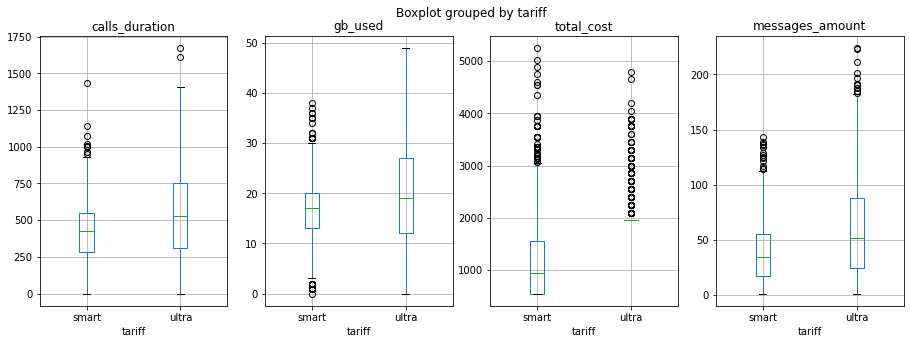

In [4]:
#считаем среднее, стандартное отклонение и дисперсию минут разговора для клиентов в месяц
#для каждого тарифа
smart_1 = total_data.query('tariff == "smart"')
print('Среднее количество потраченных минут в тарифе SMART:', smart_1[['calls_duration']].mean())
print('Стандартное отклонение потраченных минут в тарифе SMART:', smart_1[['calls_duration']].std())
print('Дисперсия потраченных минут в тарифе SMART:', np.var(smart_1[['calls_duration']]))
print('')
ultra_1 = total_data.query('tariff == "ultra"')
print('Среднее количество потраченных минут в тарифе ULTRA:', ultra_1[['calls_duration']].mean())
print('Стандартное отклонение потраченных минут в тарифе ULTRA:', ultra_1[['calls_duration']].std())
print('Дисперсия потраченных минут в тарифе ULTRA:', np.var(ultra_1[['calls_duration']]))
print('')

#считаем среднее количество сообщений для клиентов в месяц, для каждого тарифа
smart_2 = total_data.query('tariff == "smart"')
print('Среднее количество сообщений в тарифе SMART:', smart_2[['messages_amount']].mean())
print('Стандартное отклонение сообщений в тарифе SMART:', smart_2[['messages_amount']].std())
print('Дисперсия сообщений в тарифе SMART:', np.var(smart_2[['messages_amount']]))
print('')
ultra_2 = total_data.query('tariff == "ultra"')
print('Среднее количество сообщений в тарифе ULTRA:', ultra_2[['messages_amount']].mean())
print('Стандартное отклонение сообщений в тарифе ULTRA:', ultra_2[['messages_amount']].std())
print('Дисперсия сообщений в тарифе ULTRA:', np.var(ultra_2[['messages_amount']]))
print('')

#считаем средний объём интернет-трафика для клиентов в месяц, для каждого тарифа
smart_3 = total_data.query('tariff == "smart"')
print('Средний объем трафика в тарифе SMART:', smart_3[['gb_used']].mean())
print('Стандартное отклонение трафика в тарифе SMART:', smart_3[['gb_used']].std())
print('Дисперсия трафика в тарифе SMART:', np.var(smart_3[['gb_used']]))
print('')
ultra_3 = total_data.query('tariff == "ultra"')
print('Средний объем трафика в тарифе ULTRA:', ultra_3[['gb_used']].mean())
print('Стандартное отклонение трафика в тарифе ULTRA:', ultra_3[['gb_used']].std())
print('Дисперсия трафика в тарифе ULTRA:', np.var(ultra_3[['gb_used']]))
print('')

#смотрим среднее и страндартное отклонение выручки пользователей тарифов «Ультра» и «Смарт» 
smart = total_data.query('tariff == "smart"')
print('Средний средняя выручка пользователей тарифа SMART:', smart[['total_cost']].mean())
print('Стандартное отклонение выручки тарифа SMART:', smart[['total_cost']].std())
print('Дисперсия выручки тарифа SMART:', np.var(smart[['total_cost']]))
print('')

ultra = total_data.query('tariff == "ultra"')
print('Средний средняя выручка пользователей тарифа ULTRA:', ultra[['total_cost']].mean())
print('Стандартное отклонение выручки тарифа ULTRA:', ultra[['total_cost']].std())
print('Дисперсия выручки тарифа ULTRA:', np.var(ultra[['total_cost']]))

#строим диаграммы размаха для каждого тарифа
plt.subplots(figsize=(15, 5))
total_data.boxplot('calls_duration', by = 'tariff', ax=plt.subplot(1, 4, 1))
total_data.boxplot('gb_used', by = 'tariff', ax=plt.subplot(1, 4, 2))
total_data.boxplot('total_cost', by = 'tariff', ax=plt.subplot(1, 4, 3))
plot = total_data.boxplot('messages_amount', by = 'tariff', ax=plt.subplot(1, 4, 4))

**Вывод**
Пользователи тарифа "Смарт" в среднем тратят 419 минут разговора, отправляют 38 сообщений и тратят 16 Гб. Это выходит за рамки условий тарифа, поэтому мы можем сделать вывод, что пользователи тарифа "Смарт" обычно платят за дополнительные минуты, сообщения и трафик сверх тарифа. Пользователи тарифа "Ультра" в среднем тратят 545 минут разговора, отправляют 61 сообщение и тратят 19 Гб. Пользователи тратят гораздо меньше, чем указано в условиях тарифа.
В среднем выручка за месяц с пользователя тарифа "Смарт" составляет 1165 руб., а с пользователя тарифа "Ультра" составляет 2070 руб. На основании этого мы можем сделать вывод, что в среднем клиент тарифа "Ультра" приносит практически в 2 раза больше выручки за месяц.
В тарифе "Смарт" 30% пользователей тратят больше минут, чем указано в условиях их тарифа, а в тарифе "Ультра" минут хватает всем клиентам. В тарифе "Смарт" трафик сверх предложенного тратят практически 50% пользователей, а в тарифе "Ультра" - примерно 20% клиентов. В тарифе "Смарт" больше сообщений, чем  указано в условиях тарифа, отправляют примерно 30% пользователей, а в тарифе "Ультра" - 0% клиентов. Дополнительные траты сверх тарифа "Смарт" имеют 70% пользователей, а в тарифе "Ультра" у клиентов практически нет переплат сверх тарифа.

array([[<AxesSubplot:xlabel='calls_duration', ylabel='calls_duration'>,
        <AxesSubplot:xlabel='messages_amount', ylabel='calls_duration'>,
        <AxesSubplot:xlabel='gb_used', ylabel='calls_duration'>,
        <AxesSubplot:xlabel='total_cost', ylabel='calls_duration'>],
       [<AxesSubplot:xlabel='calls_duration', ylabel='messages_amount'>,
        <AxesSubplot:xlabel='messages_amount', ylabel='messages_amount'>,
        <AxesSubplot:xlabel='gb_used', ylabel='messages_amount'>,
        <AxesSubplot:xlabel='total_cost', ylabel='messages_amount'>],
       [<AxesSubplot:xlabel='calls_duration', ylabel='gb_used'>,
        <AxesSubplot:xlabel='messages_amount', ylabel='gb_used'>,
        <AxesSubplot:xlabel='gb_used', ylabel='gb_used'>,
        <AxesSubplot:xlabel='total_cost', ylabel='gb_used'>],
       [<AxesSubplot:xlabel='calls_duration', ylabel='total_cost'>,
        <AxesSubplot:xlabel='messages_amount', ylabel='total_cost'>,
        <AxesSubplot:xlabel='gb_used', ylabel='tot

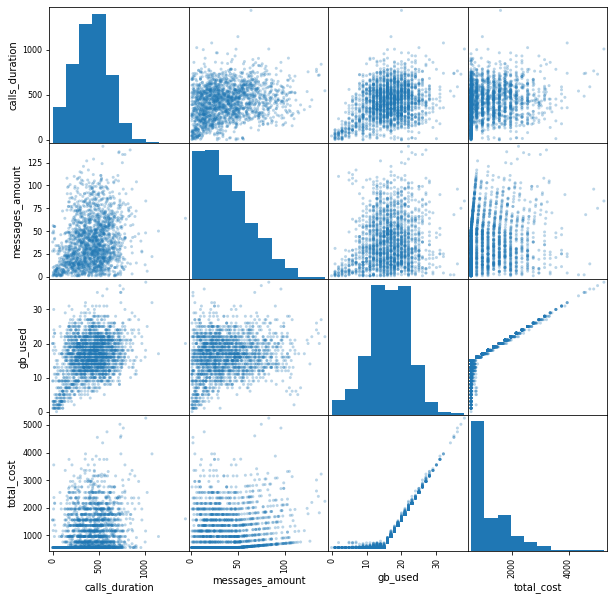

In [5]:
#строим график распределения по тарифу "Смарт"
pd.plotting.scatter_matrix(smart[['calls_duration', 'messages_amount', 'gb_used', 'total_cost']], alpha = 0.3, figsize = (10,10))

**Вывод** Распределения в тарифе "Смарт":
Кол-во минут - нормальное распределение.
Кол-во сообщений - распределение Пуассона.
Кол-во Гб - нормальное распределение.

array([[<AxesSubplot:xlabel='calls_duration', ylabel='calls_duration'>,
        <AxesSubplot:xlabel='messages_amount', ylabel='calls_duration'>,
        <AxesSubplot:xlabel='gb_used', ylabel='calls_duration'>,
        <AxesSubplot:xlabel='total_cost', ylabel='calls_duration'>],
       [<AxesSubplot:xlabel='calls_duration', ylabel='messages_amount'>,
        <AxesSubplot:xlabel='messages_amount', ylabel='messages_amount'>,
        <AxesSubplot:xlabel='gb_used', ylabel='messages_amount'>,
        <AxesSubplot:xlabel='total_cost', ylabel='messages_amount'>],
       [<AxesSubplot:xlabel='calls_duration', ylabel='gb_used'>,
        <AxesSubplot:xlabel='messages_amount', ylabel='gb_used'>,
        <AxesSubplot:xlabel='gb_used', ylabel='gb_used'>,
        <AxesSubplot:xlabel='total_cost', ylabel='gb_used'>],
       [<AxesSubplot:xlabel='calls_duration', ylabel='total_cost'>,
        <AxesSubplot:xlabel='messages_amount', ylabel='total_cost'>,
        <AxesSubplot:xlabel='gb_used', ylabel='tot

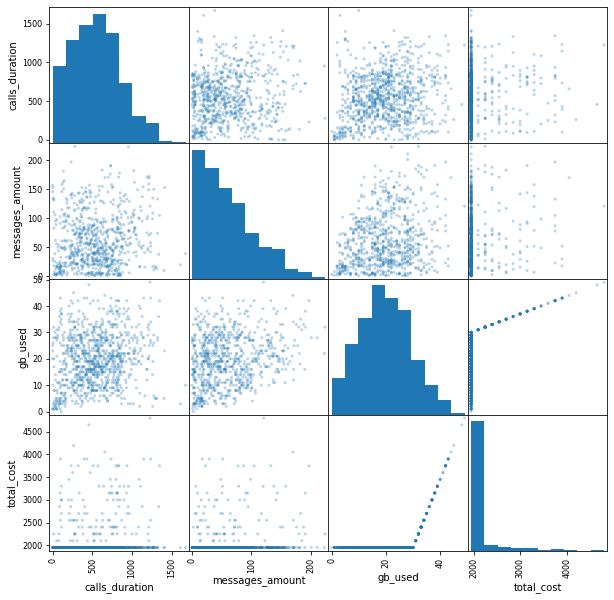

In [6]:
#строим график распределения по тарифу "Ультра"
pd.plotting.scatter_matrix(ultra[['calls_duration', 'messages_amount', 'gb_used', 'total_cost']], alpha = 0.3, figsize = (10,10))

**Вывод**Распределения в тарифе "Ультра":
Кол-во минут - нормальное распределение.
Кол-во сообщений - распределение Пуассона.
Кол-во Гб - нормальное распределение.

**Проверяем гипотизы:**
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
**Гипотиза 1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.**
Нулевая гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» равна.
Альтернативная гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» отличаются.
Критический уровень статистической значимости задаём 0.05. Т.к. дисперсии не равны пишем equal_var = False.

In [7]:
alpha = 0.05
results = st.ttest_ind(smart['total_cost'], ultra['total_cost'], equal_var = False)
print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")

P-value: 0.0
Отвергаем нулевую гипотезу.


**Вывод**
Мы отвергаем нулевую гипотизу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» равна. P-value говорит нам о том, вероятность случайного совпадения средних наших выборок ничтожно мала. Из этого следует, что альтернативная гипотеза о том, что средние указанных выборок отличаются, не отвергается.

**Гипотиза 2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.**
Нулевая гипотиза - средняя выручка пользователей из Москвы равна выручке пользователей из других регионов. Альтернативная гипотеза - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Критический уровень статистической значимости задаём 0.05. Т.к. дисперсии не равны пишем equal_var = False.

In [8]:
#создаём таблицы, в одной будут все клиенты из Москвы, в другой - все остальные пользователи
moscow = total_data[total_data['city'] == 'Москва']
other = total_data[total_data['city'] != 'Москва']

alpha = 0.05
results = st.ttest_ind(moscow['total_cost'], other['total_cost'], equal_var = False)
print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")

P-value: 0.28244700959445146
Не получилось отвергнуть нулевую гипотезу.


**Вывод**
P-value в данном случае равно 0.28. Мы не можем отвергнуть нулевую гипотезу, которая говорит нам о равенстве средних значений. Из этого следует, что альтернативную гипотезу о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов, мы отвергаем.

**Общий вывод**
**Проведена работа:** были найдены и исправлены ошибки в данных; произведена замена типа данных там, где это необходимо; произведены рассчёты и добавлены в таблицу необходимые данные(количество сделанных звонков и израсходованных минут разговора по месяцам; количество отправленных сообщений по месяцам; объем израсходованного интернет-трафика по месяцам; помесячную выручку с каждого пользователя); был проведён анализ данных; проведены рассчёты среднего количества, дисперсии и стандартного отклонения; построены графики для наглядности и дополнительных выводов; проверены гипотезы. 

**Основываясь на полученных данных можно прийти к следующему выводу:** Пользователи тарифа "Смарт" в среднем тратят 419 минут разговора, отправляют 38 сообщений и тратят 16 Гб. Это выходит за рамки условий тарифа, поэтому мы можем сделать вывод, что пользователи тарифа "Смарт" обычно платят за дополнительные минуты, сообщения и трафик сверх тарифа. Пользователи тарифа "Ультра" в среднем тратят 545 минут разговора, отправляют 61 сообщение и тратят 19 Гб. Пользователи тратят гораздо меньше, чем указано в условиях тарифа, поэтому в среднем сверх ежемесячной абонентской платы пользователи не платят. Изучив графики и проведя рассчёты, мы можем также отметить, что помимо оплаты за тариф 70% клиентов тарифа "Смарт" дополнительно оплачивают сообщения(30% клиентов), звонки(30% клиентов) и трафик(50% клиентов). У клиентов тарифа "Ультра" сверх указанной стоимости их тарифа трат практически нет(переплаты у пользователей имеются только за интернет-трафик). В среднем выручка за месяц с пользователя тарифа "Смарт" составляет 1165 руб., а с пользователя тарифа "Ультра" составляет 2070 руб., мы видим, что в среднем клиент тарифа "Ультра" приносит практически в 2 раза больше выручки за месяц. Исходя из этого делаем вывод, что тариф "Ультра" приносит больше денег компании «Мегалайн». Также на основании проведённых нами исследований мы можем сказать, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.


**Рекомендации:** Дополнительный анализ может помочь скорректировать рекламный бюджет. Например, можно изучить связь возраста клиента и приносимую им прибыль.